# Traveling salesperson problem

Lets try to now select the best route touching all the nodes in following graph:

![problem](../assets/tsp.png)

We will need to encode the problem using a QUBO formulation.

In [1]:
edges = [(1,2),(1,3),(2,3),(2,4),(3,4)]
edge_w = [5, 8, 2, 7, 4]

In [62]:
from pyqubo import Array, Constraint, Placeholder

num_assets = len(edges)
x = Array.create('x', shape=num_assets, vartype='BINARY')

# Weight added by selecting each edge
H_cost= 0.0
for i in range(num_assets):
    H_cost += Constraint(
        -edge_w[i] * x[i], label='edge({}{})'.format(edges[i][0],edges[i][1])
    )

# Constraints
# - Either 1,2 or 1,3
theta = Placeholder('theta')
H_cost += theta*Constraint((x[0] + x[1] - 1)**2, label='edges with 1')
H_cost += theta*Constraint((x[0] - x[2] - x[3])**2, label='edges with 2')
H_cost += theta*Constraint((x[0] + x[1] - 1)**2, label='edges with 1')

# - There should be at least nodes - 1 edges selected
H_cost += theta*Constraint((x[0] + x[1] + x[2] + x[3] + x[4] - 3)**2, label='edges with 1')

# Build model
model = H_cost.compile()

In [68]:
# Set the Lagrange multipliers
theta=5
feed_dict = {'theta': theta}

# Transform to QUBO.
qubo, offset = model.to_qubo(feed_dict=feed_dict)
qubo

{('x[2]', 'x[2]'): -22.0,
 ('x[1]', 'x[1]'): -43.0,
 ('x[4]', 'x[4]'): -29.0,
 ('x[3]', 'x[3]'): -27.0,
 ('x[3]', 'x[4]'): 10.0,
 ('x[0]', 'x[0]'): -35.0,
 ('x[2]', 'x[3]'): 20.0,
 ('x[1]', 'x[3]'): 10.0,
 ('x[2]', 'x[4]'): 10.0,
 ('x[1]', 'x[2]'): 10.0,
 ('x[1]', 'x[4]'): 10.0,
 ('x[0]', 'x[4]'): 10.0,
 ('x[0]', 'x[1]'): 30.0}

In [69]:
offset

55.0

First we will try to solve it using D-Wave's quantum annealer.

In [70]:
from dwave.system.samplers import DWaveSampler
from dwave.system.composites import FixedEmbeddingComposite
import minorminer
import dimod

# Instanciate Sampler
dwave_sampler = DWaveSampler()

# DWave sampler parameters
amode = 'histogram'
allowed_ta = dwave_sampler.properties['annealing_time_range'] #microsecond
num_reads=100

# Construct a problem
bqm = dimod.BinaryQuadraticModel(qubo, dimod.BINARY)

# Get the edge list
target_edgelist = dwave_sampler.edgelist

# And source edge list on the BQM quadratic model
source_edgelist = list(bqm.quadratic)

# Find the embeding
embedding = minorminer.find_embedding(source_edgelist, target_edgelist)
sampler = FixedEmbeddingComposite(dwave_sampler, embedding)

In [71]:
ta = 10 # microseconds
response = sampler.sample_qubo(qubo, num_reads=num_reads, annealing_time=ta, answer_mode=amode)
    
data = response.to_pandas_dataframe()
data["probability"] = data["num_occurrences"]/num_reads
cols = []
for i in range(num_assets):
    cols += [f'x[{i}]']
data['solution'] = data[cols].astype('str').agg(''.join, axis=1)

In [72]:
data

,x[0],x[1],x[2],x[3],x[4],chain_break_fraction,energy,num_occurrences,probability,solution
0,1,0,0,1,1,0.0,-71.0,60,0.60,10011
1,0,1,0,1,1,0.0,-69.0,22,0.22,01011
2,1,0,1,0,1,0.0,-66.0,8,0.08,10101
3,1,1,0,1,0,0.0,-65.0,1,0.01,11010
4,1,0,1,1,0,0.0,-64.0,4,0.04,10110
5,0,1,1,0,1,0.0,-64.0,1,0.01,01101
6,1,0,1,1,1,0.0,-63.0,3,0.03,10111
7,0,1,0,0,1,0.0,-62.0,1,0.01,01001


Lets take it to our QAOA setting.

In [73]:
#from QUBO to Ising Dict
ising_coeffs=dimod.qubo_to_ising(qubo, offset=offset)

# Order coefficients by the position they code 'x[0]' -> 0
h = []
jp = {}
linear = ising_coeffs[0]
quadratic = ising_coeffs[1]
for i in range(len(linear)):
    h += [linear[f'x[{i}]']]
    for j in range(len(linear)):
        if (f'x[{i}]',f'x[{j}]') in quadratic:
            jp[(i,j)] = quadratic[(f'x[{i}]',f'x[{j}]')]

print(f'Ising model linear coefficients: {h}')
print(f'Ising model quadratic coefficients: {jp}')

Ising model linear coefficients: [-7.5, -6.5, -1.0, -3.5, -4.5]
Ising model quadratic coefficients: {(0, 1): 7.5, (0, 4): 2.5, (1, 2): 2.5, (1, 3): 2.5, (1, 4): 2.5, (2, 3): 5.0, (2, 4): 2.5, (3, 4): 2.5}


In [74]:
from cmath import pi
from qiskit import QuantumCircuit

# Mixer
def U_B(circ: QuantumCircuit, param): 
    for qubit in range(circ.num_qubits):
        circ.rx(param, qubit)
        
# unitary operator U_C with parameter gamma
def U_C(circ: QuantumCircuit, param, h, jp): 
    for key in jp.keys():
        q1 = key[0]
        q2 = key[1]
        circ.rzz(jp[key]*param, q1, q2)
        
    for qubit in range(circ.num_qubits):
        circ.rz(h[qubit]*param, qubit)
        
def circuit(num_assets, params, n_layers, h, jp):
    
    circ = QuantumCircuit(num_assets, num_assets)
    
    # apply Hadamards to get the n qubit |+> state
    for qubit in range(num_assets):
        circ.h(qubit)
        
    # p instances of unitary operators
    for i in range(n_layers):
        init = i*2
        U_C(circ, params[init], h, jp)
        U_B(circ, params[init+1])
        
    circ.measure(range(num_assets), range(num_assets))
    
    return circ


In [78]:
def compute_expectation(counts, h, jp, nshots):
    
    """
    Computes expectation value based on measurement results. It needs to be ajusted so that the distribution of 
    counts matches with the expected groud state or at least a narrow distribution against a minimal one.
    """   
    def get_energy(solution):
        # Ising problem
        val = 0.0
        for i in range(len(solution)):
            val += -h[i]*solution[i]
            
        for key in jp.keys():
                val += jp[key]*solution[key[0]]*solution[key[1]]
        return val
    
    min_energy = 0.0
    min_e_perc = 0.0
    for key in counts: # Iterates for all counts obtained (2**n)
        solution = [int(item)*2-1 for item in key]
        output = get_energy(solution)
            
        if output < min_energy:
            min_energy = output
            min_e_perc = counts[key]/nshots
    
    # Return the value of the minimum energy found scaled to its probability
    return min_energy*min_e_perc


# Finally we write a function that executes the circuit on the chosen backend
def get_expectation(n_layers, h, jp, backend, nshots=1024):
    
    """
    Runs parametrized circuit
    """
    def execute_circ(params):
        
        qc = circuit(len(h), params, n_layers, h, jp)
        counts = backend.run(qc, seed_simulator=10, nshots=nshots).result().get_counts()
        
        return compute_expectation(counts, h, jp, nshots)
    
    return execute_circ

In [79]:
from qiskit import Aer

backend = Aer.get_backend("qasm_simulator")

In [89]:
import numpy as np
from scipy.optimize import basinhopping

num_layers = 2
num_params = 2
minimizer_kwargs = {"method": "COBYLA"}

params = np.random.rand(num_layers*num_params)
expectation = get_expectation(num_layers, h, jp, backend)

# Using global optimizer
results = basinhopping(expectation, params, minimizer_kwargs=minimizer_kwargs, niter=200)

In [90]:
results

                        fun: -8.34814453125
 lowest_optimization_result:      fun: -8.34814453125
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 46
  status: 1
 success: True
       x: array([7.5375709 , 5.33255744, 7.45268662, 2.069658  ])
                    message: ['requested number of basinhopping iterations completed successfully']
      minimization_failures: 0
                       nfev: 9398
                        nit: 200
                    success: True
                          x: array([7.5375709 , 5.33255744, 7.45268662, 2.069658  ])

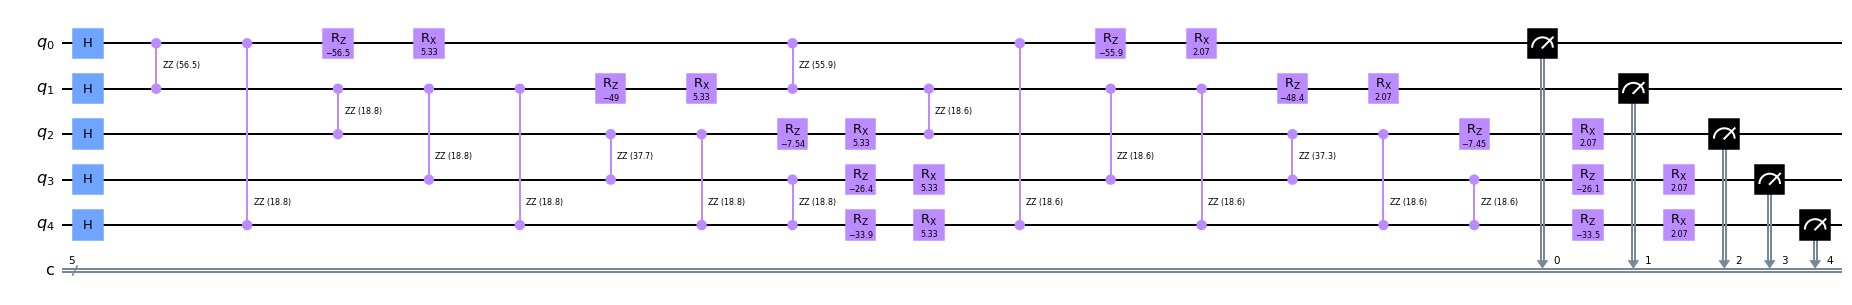

In [91]:
circ = circuit(len(h), results.x, num_layers, h, jp)
circ.draw('mpl', fold=120)

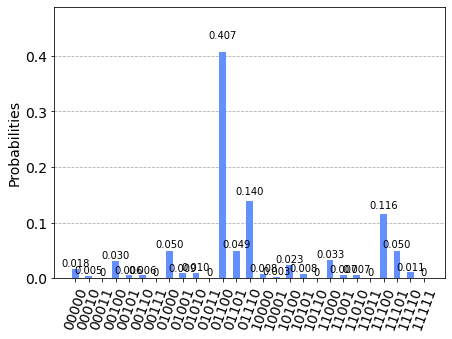

In [92]:
from qiskit.visualization import plot_histogram

nshots=500
counts = backend.run(circ, seed_simulator=10, nshots=nshots).result().get_counts()
plot_histogram(counts)

In [96]:
max_c = ""
perc = 0.0
for c in counts:
    if counts[c]/nshots > perc:
        max_c = c[::-1]
        perc = counts[c]/nshots
print(f"Found solution {max_c} with success probability {perc}")
print(f"Selected edges:")
for i, val in enumerate(max_c):
    if val == "1":
        print(edges[i])


Found solution 00110 with success probability 0.834
Selected edges:
(2, 3)
(2, 4)
